In [49]:
from torchvision import transforms
import numpy as np
import torch
from torch import Tensor
from torch import nn
from torch.functional import F
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
from typing import Dict, Tuple, Union, NewType, List, Optional, Any
from pathlib import Path, WindowsPath
import warnings
import pickle
warnings.filterwarnings("ignore")
import seaborn as sns


from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

def load_obj(path: str) -> Any:
    with open(path, 'rb') as f:
        return pickle.load(f)
    

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def visu(original_image, transformer_attribution, file_name: str, save_vis: bool=False):
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (
            transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (
            image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    if save_vis:
        plt.imsave(fname=Path('plots', f'{file_name}.png'), arr=vis, format='png')
    else:
        display(transforms.ToPILImage()(vis))
        
def perbutation(model, vis, pic, target_class):
    """
    vis.shape: (n_tokens, )
    _data.shape: ([3, 224, 224])
    """
    
    base_size = 224 * 224
    perturbation_steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    org_shape = (1, 3, 224, 224)
    fig, axs = plt.subplots(3, 3)
    _data = pic.clone()
    vis_picture = torch.tensor(patch_score_to_image(vis).reshape(-1))
    inputs = feature_extractor(images=pic.squeeze(0), return_tensors="pt")
    out = model(**inputs)
    print(f'Original Image. Top Class: {out.logits[0].argmax(dim=0).item()}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob: {round(F.softmax(out.logits[0], dim=-1).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0], dim=-1)[target_class].item(), 5)}')    
#     print(f'Original Image. Top Class: {model.config.id2label[out.logits[0].argmax(dim=0).item()]}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob: {round(F.softmax(out.logits[0], dim=-1).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0], dim=-1)[target_class].item(), 5)}')    
    for i in range(len(perturbation_steps)):
        _, idx = torch.topk(vis_picture, int(base_size * perturbation_steps[i]), dim=-1) # vis.shape (50176) / 2 = 25088
        idx = idx.unsqueeze(1).repeat(1, org_shape[1], 1)
        _data = _data.reshape(org_shape[0], org_shape[1], -1)
        _data = _data.scatter_(-1, idx.reshape(1, 3, -1), 0)
        _data = _data.reshape(*org_shape)

        im = transforms.ToPILImage()(_data.squeeze(0))
        plt.imshow(im)
        plt.subplot(3,3,i+1)
        plt.imshow(im)
        plt.title(f'{100 * perturbation_steps[i]}%')
        plt.subplots_adjust(hspace=0.6, wspace=0.2)
        inputs = feature_extractor(images=_data.squeeze(0), return_tensors="pt")
        out = model(**inputs)
        print(f'{100 * perturbation_steps[i]}% pixels blacked. Top Class: {out.logits[0].argmax(dim=0).item()}, changed original: {out.logits[0].argmax(dim=0).item() != target_class}')
#         print(f'{100 * perturbation_steps[i]}% pixels blacked. Top Class: {out.logits[0].argmax(dim=0).item()}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob: {round(F.softmax(out.logits[0], dim=-1).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0], dim=-1)[target_class].item(), 5)}')
#         print(f'{perturbation_steps[i]}% pixels blacked. Top Class: {model.config.id2label[out.logits[0].argmax(dim=0).item()]}, Max logits: {round(out.logits[0].max(dim=0)[0].item(), 2)}, Max prob: {round(F.softmax(out.logits[0], dim=-1).max(dim=0)[0].item(), 2)}; Correct class logit: {round(out.logits[0][target_class].item(), 2)} Correct class prob: {round(F.softmax(out.logits[0], dim=-1)[target_class].item(), 5)}')        
    
IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=IMAGENET_STANDARD_MEAN, std=IMAGENET_STANDARD_STD)
image_transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#     normalize,
])

def patch_score_to_image(transformer_attribution):
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (
            transformer_attribution.max() - transformer_attribution.min())
    return transformer_attribution


In [114]:
tokens_mask_path = r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\research_heads\0000000002\90\cls_tokens.pkl"
# tokens_mask_path = r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\research_heads\0000000002\0\cls_iter_0.pkl"
image_path = r"C:\Users\asher\OneDrive\Documents\Data Science Degree\Tesis\Explainability NLP\explainablity-transformer\research\plots\research_heads\0000000002\224x224.JPEG"
mask = load_obj(tokens_mask_path)
image = Image.open(image_path)
image = image_transformations(image)
# visu(image, mask.median(dim=0)[0], 'test', save_vis=False)

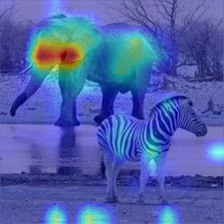

In [115]:
visu(image, mask.mean(dim=0), 'test', save_vis=False)

In [116]:
pic = Image.open(image_path)
pic = image_transformations(pic)

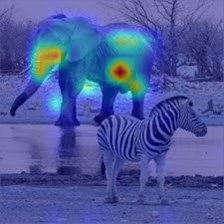

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 9, changed original: True
50.0% pixels blacked. Top Class: 347, changed original: True
60.0% pixels blacked. Top Class: 920, changed original: True
70.0% pixels blacked. Top Class: 920, changed original: True
80.0% pixels blacked. Top Class: 920, changed original: True
90.0% pixels blacked. Top Class: 471, changed original: True


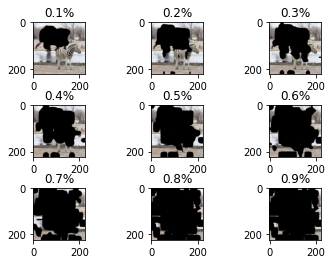

In [121]:
vis = mask[0]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

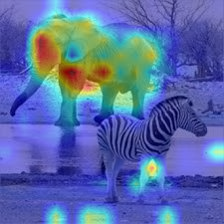

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 340, changed original: True
60.0% pixels blacked. Top Class: 340, changed original: True
70.0% pixels blacked. Top Class: 340, changed original: True
80.0% pixels blacked. Top Class: 340, changed original: True
90.0% pixels blacked. Top Class: 340, changed original: True


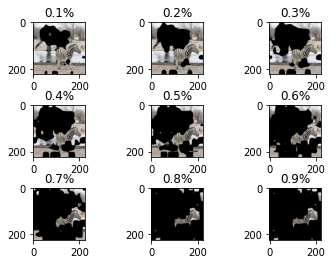

In [122]:
vis = mask[1]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

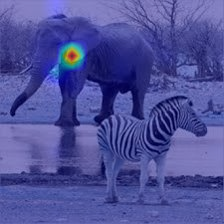

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 340, changed original: True
60.0% pixels blacked. Top Class: 340, changed original: True
70.0% pixels blacked. Top Class: 340, changed original: True
80.0% pixels blacked. Top Class: 340, changed original: True
90.0% pixels blacked. Top Class: 340, changed original: True


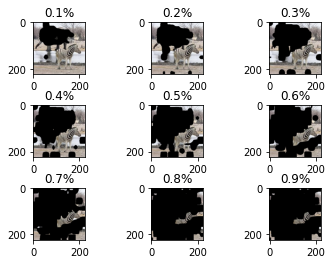

In [124]:
vis = mask[2]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

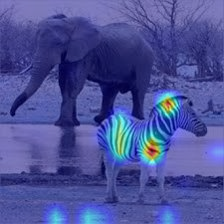

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 386, changed original: True
20.0% pixels blacked. Top Class: 386, changed original: True
30.0% pixels blacked. Top Class: 386, changed original: True
40.0% pixels blacked. Top Class: 385, changed original: True
50.0% pixels blacked. Top Class: 385, changed original: True
60.0% pixels blacked. Top Class: 385, changed original: True
70.0% pixels blacked. Top Class: 743, changed original: True
80.0% pixels blacked. Top Class: 471, changed original: True
90.0% pixels blacked. Top Class: 819, changed original: True


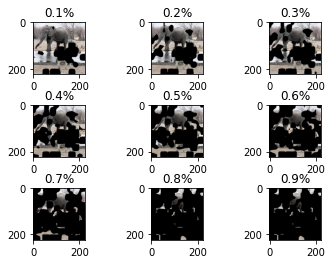

In [125]:
vis = mask[3]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

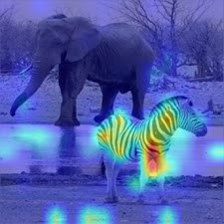

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 386, changed original: True
20.0% pixels blacked. Top Class: 386, changed original: True
30.0% pixels blacked. Top Class: 386, changed original: True
40.0% pixels blacked. Top Class: 386, changed original: True
50.0% pixels blacked. Top Class: 386, changed original: True
60.0% pixels blacked. Top Class: 386, changed original: True
70.0% pixels blacked. Top Class: 386, changed original: True
80.0% pixels blacked. Top Class: 470, changed original: True
90.0% pixels blacked. Top Class: 851, changed original: True


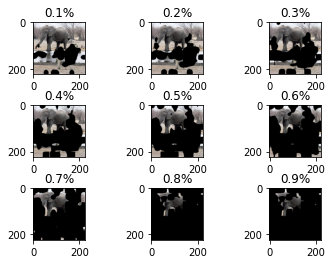

In [126]:
vis = mask[4]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

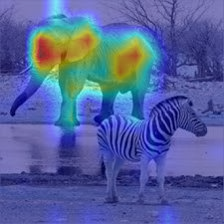

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 843, changed original: True
60.0% pixels blacked. Top Class: 920, changed original: True
70.0% pixels blacked. Top Class: 920, changed original: True
80.0% pixels blacked. Top Class: 920, changed original: True
90.0% pixels blacked. Top Class: 920, changed original: True


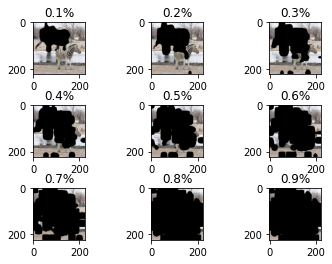

In [127]:
vis = mask[5]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

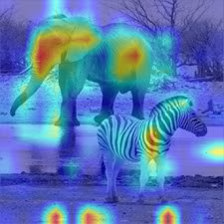

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 843, changed original: True
50.0% pixels blacked. Top Class: 439, changed original: True
60.0% pixels blacked. Top Class: 347, changed original: True
70.0% pixels blacked. Top Class: 843, changed original: True
80.0% pixels blacked. Top Class: 51, changed original: True
90.0% pixels blacked. Top Class: 498, changed original: True


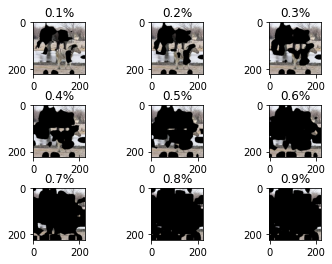

In [128]:
vis = mask[6]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

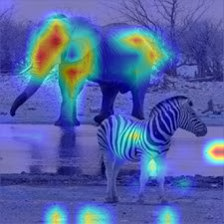

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 340, changed original: True
60.0% pixels blacked. Top Class: 920, changed original: True
70.0% pixels blacked. Top Class: 843, changed original: True
80.0% pixels blacked. Top Class: 439, changed original: True
90.0% pixels blacked. Top Class: 652, changed original: True


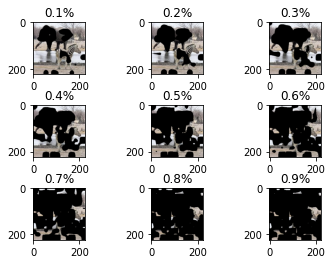

In [129]:
vis = mask[7]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

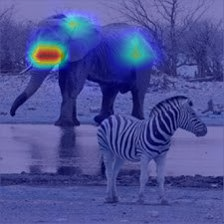

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 232, changed original: True
50.0% pixels blacked. Top Class: 920, changed original: True
60.0% pixels blacked. Top Class: 920, changed original: True
70.0% pixels blacked. Top Class: 920, changed original: True
80.0% pixels blacked. Top Class: 920, changed original: True
90.0% pixels blacked. Top Class: 471, changed original: True


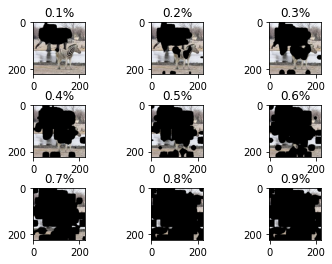

In [130]:
vis = mask[8]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

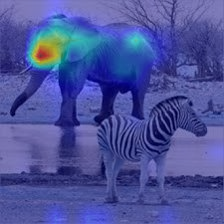

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 340, changed original: True
60.0% pixels blacked. Top Class: 340, changed original: True
70.0% pixels blacked. Top Class: 920, changed original: True
80.0% pixels blacked. Top Class: 920, changed original: True
90.0% pixels blacked. Top Class: 471, changed original: True


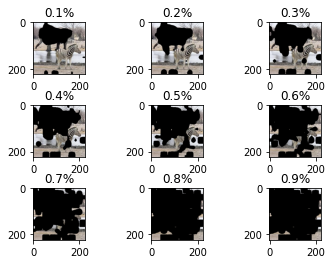

In [131]:
vis = mask[9]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

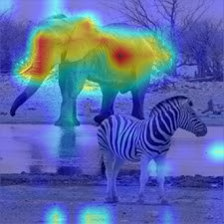

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 340, changed original: True
60.0% pixels blacked. Top Class: 340, changed original: True
70.0% pixels blacked. Top Class: 340, changed original: True
80.0% pixels blacked. Top Class: 764, changed original: True
90.0% pixels blacked. Top Class: 743, changed original: True


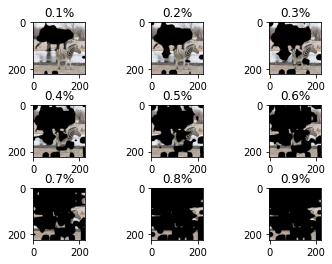

In [132]:
vis = mask[10]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)

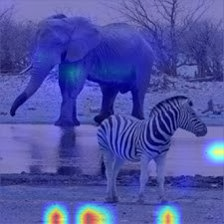

Original Image. Top Class: 101, Max logits: 11.08, Max prob:: 0.34; Correct class logit: 11.08 Correct class prob: 0.34302
10.0% pixels blacked. Top Class: 340, changed original: True
20.0% pixels blacked. Top Class: 340, changed original: True
30.0% pixels blacked. Top Class: 340, changed original: True
40.0% pixels blacked. Top Class: 340, changed original: True
50.0% pixels blacked. Top Class: 340, changed original: True
60.0% pixels blacked. Top Class: 347, changed original: True
70.0% pixels blacked. Top Class: 398, changed original: True
80.0% pixels blacked. Top Class: 398, changed original: True
90.0% pixels blacked. Top Class: 401, changed original: True


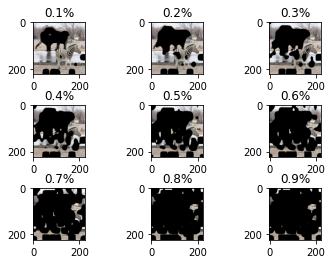

In [133]:
vis = mask[11]
visu(image, vis,  '', save_vis=False)
perbutation(model=model, vis=vis, pic=pic, target_class=target_class)